# Inits

In [159]:
from pymed import PubMed
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import matplotlib.pyplot as plt
import pickle

# Establishing constants

## get_abstracts function
Given a PMID, retrieves the abstract for the article

In [103]:
def get_abstracts(PMID):
    pm = PubMed(tool = "MyTool", email = "rutecki.ja@northeastern.edu")
    res = pm.query(f"{PMID}[PMID]", max_results = 1)
    for art in res:
        time.sleep(1) # sleep timer to avoid too many requests from PubMed
        return art.toDict()["abstract"]

## Building training and test sets

In [52]:
# papers that we want
PMID_des_pap = np.array([
    27661255, # Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation
    39626969, # Structure-optimized sgRNA selection with PlatinumCRISPr for efficient Cas9 generation of knockouts
    39019250, # Functional genomic screening in Komagataella phaffii enabled by high-activity CRISPR-Cas9 library
    39278589, # Optimized genome-wide CRISPR screening enables rapid engineering of growth-based phenotypes in Yarrowia lipolytica
    36576240, # Maximizing CRISPRi efficacy and accessibility with dual-sgRNA libraries and optimal effectors
    37464007, # Optimized minimal genome-wide human sgRNA library
    25184501, # Rational design of highly active sgRNAs for CRISPR-Cas9-mediated gene inactivation
    26063738, # Sequence determinants of improved CRISPR sgRNA design
    33451939, # SeqCor: correct the effect of guide RNA sequences in clustered regularly interspaced short palindromic repeats/Cas9 screening by machine learning algorithm
])

# papers we do not want (for training model)
# this was made in a really lazy way, might end up confounding info but we'll see
pubmed = PubMed(tool = "MyTool", email = "rutecki.ja@northeastern.edu")
res = pubmed.query("CRISPR", max_results = 10)
PMID_undes_pap = []
for article in res:
    PMID_undes_pap.append(article.toDict()["pubmed_id"].split("\n"))
PMID_undes_pap = np.array([int(item) for sublist in PMID_undes_pap for item in sublist])

# get rid of any duplicate papers, keep only unique papers
PMID_undes_pap = np.unique(np.setdiff1d(PMID_undes_pap, PMID_des_pap))

# keywords to be searched into pubmed
keywords = (
    "CRISPRi sgRNA library",
    "sgRNA libraray",
    "sgRNA efficiency",
    "CRISPRi sgRNA efficiency"
)

# total number of papers we plan on looking at 
num_pap = 5000

## Getting abstract for each PMID
Needs to be a 1s delay between each query - given that the dataframe is ~280 papers, this takes around 5 minutes to run

In [165]:
# df = pd.concat([pd.DataFrame({"PMID": PMID_des_pap, "lab": 1}),
#                 pd.DataFrame({"PMID": PMID_undes_pap, "lab": 0})])
# df["abs"] = df["PMID"].apply(get_abstracts)
# with open("models/df.pk1", "wb") as file:
#     pickle.dump(df, file)

with open("models/df.pk1", "rb") as file:
    df = pickle.load(file)

# Data preprocessing for model fitting

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer()

df["abs"] = df["abs"].fillna("missing")
X = vect.fit_transform(df["abs"])
y = df["lab"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# SVM Approach

## Fitting model

In [162]:
# param_grid = {
#     "C": Real(1E-6, 1E6, prior = "log-uniform")
# }

# mod = SVC(kernel = "linear")

# tuned_mod = BayesSearchCV(mod, param_grid)
# tuned_mod.fit(X_train, y_train)
# with open("models/abstract_SVC.pk1", "wb") as file:
#     pickle.dump(tuned_mod.best_estimator_, file)

with open("models/abstract_SVC.pk1", "rb") as file:
    tuned_mod = pickle.load(file)

## Model metrics

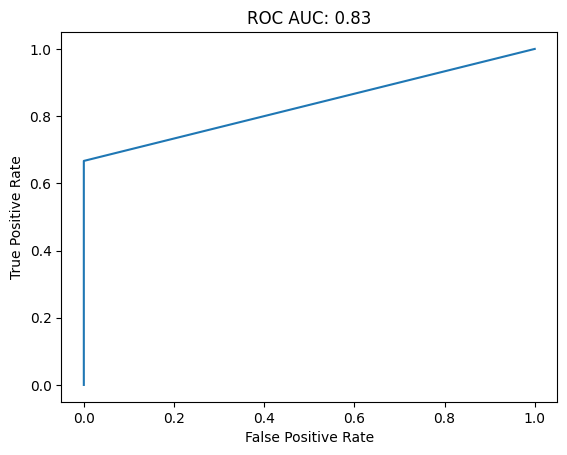

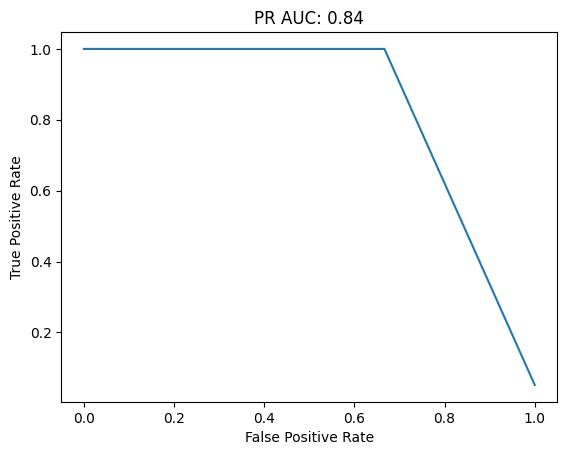

Accuracy: 0.9827586206896551
Precision: 1.0
Recall: 0.6666666666666666
F1 Score: 0.8


In [163]:
y_pred = tuned_mod.predict(X_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC AUC: {round(auc(fpr, tpr), 2)}")
plt.show()

# PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"PR AUC: {round(auc(recall, precision), 2)}")
plt.show()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')